In [1]:
!pip install diffusers["torch"] transformers
!pip install diffusers["flax"] transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 33.4 MB/s eta 0:00:00


In [10]:
from diffusers import DDPMScheduler, UNet2DModel

# Load Model & Scheduler
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

# Set no. of steps for Denoising
# Denoising is an advanced technique used to decrease grainy spots and discoloration in images while minimizing the loss of quality
scheduler.set_timesteps(50)

# Time Step in which model denoise an image
scheduler.timesteps


tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [11]:
import torch

# Create random denoise with same shape as desired output
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")


In [12]:
# loop to iterate over the timesteps. At each timestep, the model does a UNet2DModel.forward() pass and returns the noisy residual.
# The scheduler’s step() method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep.
# This output becomes the next input to the model in the denoising loop, and it’ll repeat until it reaches the end of the timesteps array.

input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

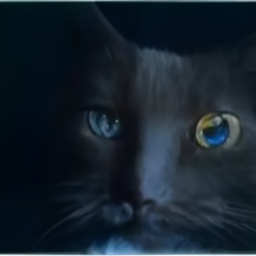

In [13]:
# Convert denoised output to an image
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image